In [ ]:
import os
import zipfile

# Descargar dataset desde Kaggle
dataset_path = "alzheimers_data"
kaggle_dataset = "yiweilu2033/well-documented-alzheimers-dataset"

# Crear la carpeta si no existe
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_path} --unzip")
    print("Dataset descargado y descomprimido en:", dataset_path)
else:
    print("El dataset ya está descargado.")


El dataset ya está descargado.


In [ ]:
import os


# Verificar si la ruta del dataset existe
if not os.path.exists(dataset_path):
    print("Error: La ruta del dataset no existe.")
else:
    # Diccionario para almacenar el número de imágenes por clase
    image_counts = {}

    # Recorrer las carpetas dentro del dataset
    for class_name in sorted(os.listdir(dataset_path)):  # Ordenar alfabéticamente
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):  # Verificar que es una carpeta
            num_images = 0

            # Recorrer todos los archivos en la carpeta y sus subcarpetas
            for root, _, files in os.walk(class_path):
                num_images += sum(1 for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')))

            image_counts[class_name] = num_images

    # Mostrar el número de imágenes por clase
    for class_name, count in image_counts.items():
        print(f" {class_name}: {count} imágenes")

    # Mostrar total de imágenes en todo el dataset
    total_images = sum(image_counts.values())
    print(f"\n Total de imágenes en el dataset: {total_images}")


 MildDemented: 5184 imágenes
 ModerateDemented: 376 imágenes
 NonDemented (2): 63560 imágenes
 VeryMildDemented: 13796 imágenes

 Total de imágenes en el dataset: 82916


In [ ]:
import os
import shutil
import random

# Ruta del dataset original
dataset_path = "alzheimers_data"  # Ajusta si es necesario
output_base = "alzheimers_split"  # Carpeta donde guardaremos train/val/test

# Ratios de división
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Asegurar que la carpeta de salida no existe para evitar mezclar datos
if not os.path.exists(output_base):
    os.makedirs(output_base)

    for category in sorted(os.listdir(dataset_path)):  # Ordenamos las clases
        class_path = os.path.join(dataset_path, category)

        if os.path.isdir(class_path):
            # Obtener todas las imágenes dentro de la carpeta, incluyendo subcarpetas
            images = []
            for root, _, files in os.walk(class_path):
                images += [os.path.join(root, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            # Asegurar que hay imágenes en la categoría
            if len(images) == 0:
                print(f"⚠️ {category}: No se encontraron imágenes. Saltando...")
                continue

            # Mezclar aleatoriamente las imágenes con semilla fija para mantener la misma distribución siempre
            random.seed(42)
            random.shuffle(images)

            # Dividir en train, val y test
            train_split = int(len(images) * train_ratio)
            val_split = int(len(images) * (train_ratio + val_ratio))

            train_images = images[:train_split]
            val_images = images[train_split:val_split]
            test_images = images[val_split:]

            # Copiar imágenes a las carpetas de destino
            for split_name, img_list in zip(["train", "val", "test"], [train_images, val_images, test_images]):
                split_path = os.path.join(output_base, split_name, category)
                os.makedirs(split_path, exist_ok=True)

                for img in img_list:
                    shutil.copy2(img, os.path.join(split_path, os.path.basename(img)))  # Copia con nombre original

            print(f"✅ {category}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")
else:
    print("⚠️ Las imágenes ya fueron organizadas. Si deseas regenerarlas, elimina la carpeta 'alzheimers_split'.")


⚠️ Las imágenes ya fueron organizadas. Si deseas regenerarlas, elimina la carpeta 'alzheimers_split'.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformaciones (iguales para todos)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Rutas de los conjuntos ya divididos
train_path = "alzheimers_split/train"
val_path = "alzheimers_split/val"
test_path = "alzheimers_split/test"

# Cargar datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Crear DataLoaders
batch_size = 128
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 66331, Validation: 8292, Test: 8293


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()

        # Bloque 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloque 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calcular el tamaño de entrada para la capa densa
        self.flattened_size = self._get_flattened_size()

        # Capas densas
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _get_flattened_size(self):
        """Calcula automáticamente el tamaño de la salida antes de la capa fully connected."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)  # Imagen de ejemplo
            x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
            x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


# Inicializar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerCNN(num_classes=4).to(device)
print(model)


AlzheimerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import time

# Configuración de hiperparámetros
criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam
num_epochs = 25  # Número de épocas

# Entrenamiento del modelo
start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reiniciar gradientes
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Cálculo de pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total

    # Evaluación en validación
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

training_time = time.time() - start_time
print(f"\nTiempo total de entrenamiento: {training_time:.2f} segundos")

# Guardar modelo entrenado
torch.save(model.state_dict(), "alzheimers_model.pth")
print("Modelo guardado como 'alzheimers_model.pth'")


Epoch [1/25] - Loss: 0.5373, Accuracy: 77.85%, Val Loss: 0.4413, Val Accuracy: 79.67%
Epoch [2/25] - Loss: 0.4470, Accuracy: 79.74%, Val Loss: 0.3997, Val Accuracy: 82.03%
Epoch [3/25] - Loss: 0.4067, Accuracy: 81.52%, Val Loss: 0.3747, Val Accuracy: 84.50%
Epoch [4/25] - Loss: 0.3677, Accuracy: 83.59%, Val Loss: 0.3238, Val Accuracy: 86.17%
Epoch [5/25] - Loss: 0.3661, Accuracy: 83.97%, Val Loss: 0.2998, Val Accuracy: 88.05%
Epoch [6/25] - Loss: 0.3143, Accuracy: 86.35%, Val Loss: 0.2525, Val Accuracy: 89.70%
Epoch [7/25] - Loss: 0.2853, Accuracy: 87.81%, Val Loss: 0.2449, Val Accuracy: 89.95%
Epoch [8/25] - Loss: 0.2598, Accuracy: 89.00%, Val Loss: 0.2101, Val Accuracy: 91.84%
Epoch [9/25] - Loss: 0.2444, Accuracy: 89.91%, Val Loss: 0.2176, Val Accuracy: 91.73%
Epoch [10/25] - Loss: 0.2283, Accuracy: 90.59%, Val Loss: 0.1905, Val Accuracy: 92.84%
Epoch [11/25] - Loss: 0.2139, Accuracy: 91.40%, Val Loss: 0.1520, Val Accuracy: 94.90%
Epoch [12/25] - Loss: 0.1998, Accuracy: 92.04%, Val 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


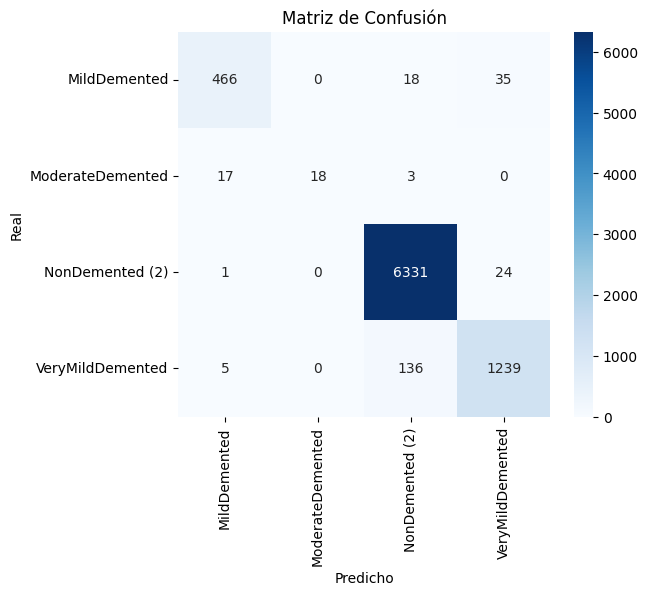


Reporte de clasificación:
                   precision    recall  f1-score   support

    MildDemented       0.95      0.90      0.92       519
ModerateDemented       1.00      0.47      0.64        38
 NonDemented (2)       0.98      1.00      0.99      6356
VeryMildDemented       0.95      0.90      0.93      1380

        accuracy                           0.97      8293
       macro avg       0.97      0.82      0.87      8293
    weighted avg       0.97      0.97      0.97      8293



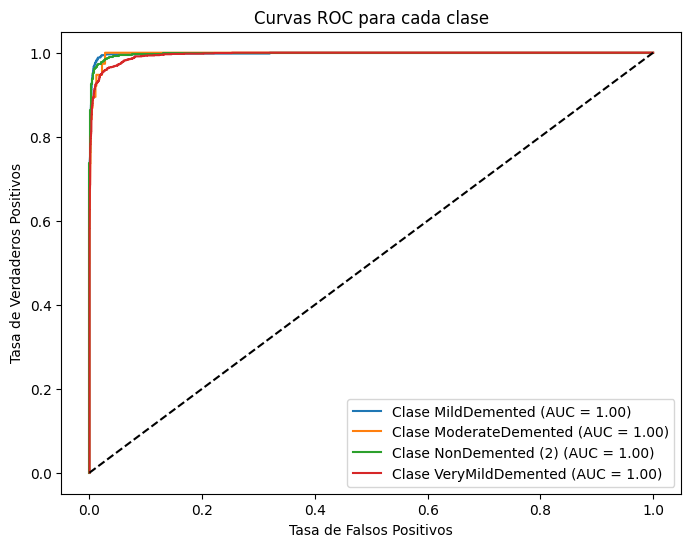

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F

# ===============================
# 1. CARGAR MODELO ENTRENADO
# ===============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerCNN(num_classes=4).to(device)
model.load_state_dict(torch.load("alzheimers_model.pth"))
model.eval()

# ===============================
# 2. EVALUACIÓN EN TEST SET
# ===============================

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:  # Asegúrate de que test_loader está definido
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        probs = F.softmax(outputs, dim=1)  # Convertir logits a probabilidades
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ===============================
# 3. MATRIZ DE CONFUSIÓN
# ===============================

cm = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes  # Obtener nombres de las clases

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\nReporte de clasificación:\n", classification_report(all_labels, all_preds, target_names=class_names))

# ===============================
# 4. CURVA ROC
# ===============================

plt.figure(figsize=(8, 6))

for i in range(4):  # 4 clases
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC para cada clase")
plt.legend()
plt.show()
